# Neural Data Processing Notebook
### Kyle McGraw, February 2025

A notebook to explore a publicly available dataset on [neural population dynamics during reaching](https://dandiarchive.org/dandiset/000070)

In [191]:
# Imports
import os
from enum import Enum
from pynwb import NWBHDF5IO

import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.stats import binned_statistic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

In [2]:
# Load an example file to explore
file_path = "data/000070/sub-Jenkins/sub-Jenkins_ses-20090912_behavior+ecephys.nwb"

# Open the NWB file
io = NWBHDF5IO(file_path, mode='r', load_namespaces=True)
example_data = io.read()

example_data

/Users/kylemcgraw/Documents/neural-data-exploration/venv/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/kylemcgraw/Documents/neural-data-exploration/venv/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Data type,float64
Shape,"(4696343, 2)"
Array size,71.66 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(4696343,)"
Array size,35.83 MiB
Chunk shape,None


In [114]:
subject = ["Jenkins", "Nitschke"]

full_data = {}
# Load all files for each subject
for s in subject:
    full_data[s] = {}
    subject_path = f"data/000070/sub-{s}"
    
    # Get all .nwb files in subject directory
    nwb_files = [f for f in os.listdir(subject_path) if f.endswith('.nwb')]
    
    # Load each file for this subject
    for nwb_file in nwb_files:
        file_path = os.path.join(subject_path, nwb_file)
        
        # Open the NWB file and store in nested dictionary
        io = NWBHDF5IO(file_path, mode='r', load_namespaces=True)
        session_name = nwb_file.split('_')[1]  # Get session name from filename
        full_data[s][session_name] = io.read()

/Users/kylemcgraw/Documents/neural-data-exploration/venv/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/kylemcgraw/Documents/neural-data-exploration/venv/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


# Exploring the data

## Behavioral Data

In [3]:
# Get the behavior module
behavior_module = example_data.processing["behavior"]
behavior_module

Data type,float64
Shape,"(4696343, 2)"
Array size,71.66 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(4696343,)"
Array size,35.83 MiB
Chunk shape,None


In [4]:
# Get the position data
position = behavior_module.get("Position")
position

Data type,float64
Shape,"(4696343, 2)"
Array size,71.66 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(4696343,)"
Array size,35.83 MiB
Chunk shape,None


In [5]:
# Get an example spatial series
spatial_series = position.spatial_series["Eye"]
spatial_series

Data type,float64
Shape,"(4696343, 2)"
Array size,71.66 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(4696343,)"
Array size,35.83 MiB
Chunk shape,None


In [6]:
# Take a look at the data and timestamps
eye_data = spatial_series.data
eye_timestamps = spatial_series.timestamps

print(f"Data shape: {eye_data.shape}")
print(f"Timestamps shape: {eye_timestamps.shape}")

Data shape: (4696343, 2)
Timestamps shape: (4696343,)


In [7]:
eye_timestamps[0]

np.float64(64.55126666666666)

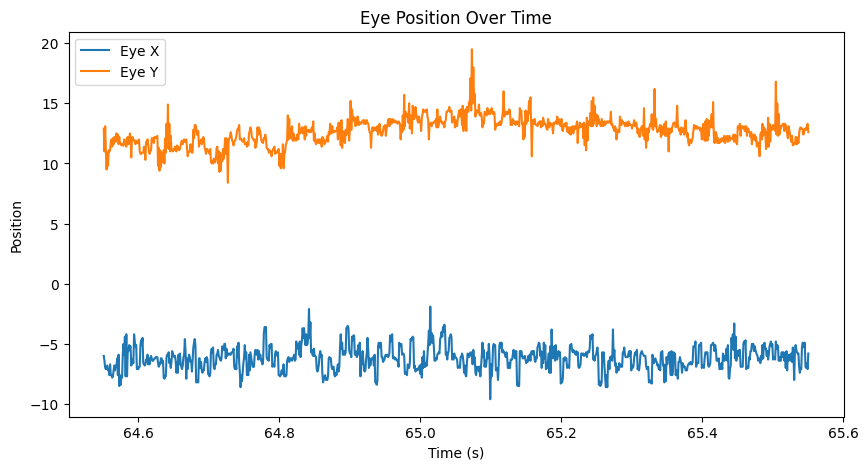

In [8]:
# Plot a portion of the data
plt.figure(figsize=(10, 5))
plt.plot(eye_timestamps[:1000], eye_data[:1000, 0], label="Eye X")
plt.plot(eye_timestamps[:1000], eye_data[:1000, 1], label="Eye Y")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.title("Eye Position Over Time")
plt.legend()
plt.show()

## Electrophysiological Data

In [9]:
# Get the ecephys module
ecephys_module = example_data.processing["ecephys"]
ecephys_module

ecephys pynwb.base.ProcessingModule at 0x5289301808
Fields:
  data_interfaces: {
    Processed <class 'pynwb.ecephys.FilteredEphys'>
  }
  description: Intermediate data from extracellular electrophysiology recordings, e.g., LFP.

In [10]:
# Get the processed data
processed = ecephys_module.get("Processed")
processed

Processed pynwb.ecephys.FilteredEphys at 0x5289431968
Fields:
  electrical_series: {
    A001 <class 'pynwb.ecephys.ElectricalSeries'>,
    A002 <class 'pynwb.ecephys.ElectricalSeries'>,
    B001 <class 'pynwb.ecephys.ElectricalSeries'>,
    B002 <class 'pynwb.ecephys.ElectricalSeries'>
  }

In [11]:
# Get an example electrical series
electrical_series = processed.electrical_series["A001"]
electrical_series

A001 pynwb.ecephys.ElectricalSeries at 0x5289303440
Fields:
  comments: Generated from SpikeInterface::NwbRecordingExtractor
  conversion: 1e-06
  data: <HDF5 dataset "data": shape (7464590, 96), type "<i2">
  description: LFP signal for array A, segment 1data for both arrays A,B in the same segment should be, but is not of the same time lengthand cannot be synced due to lack of time stamps. Ignore the starting times.
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  offset: 0.0
  rate: 1000.0
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: volts

In [12]:
# Get the data and timestamps
a1_data = electrical_series.data

# NOTE: This is not acutally correct as there are not actually timestamps
# TODO: If using this data with other data, ensure timestamps are aligned
a1_timestamps = electrical_series.starting_time + np.arange(a1_data.shape[0]) / electrical_series.rate

print(f"Data shape: {a1_data.shape}")
print(f"Timestamps shape: {a1_timestamps.shape}")

Data shape: (7464590, 96)
Timestamps shape: (7464590,)


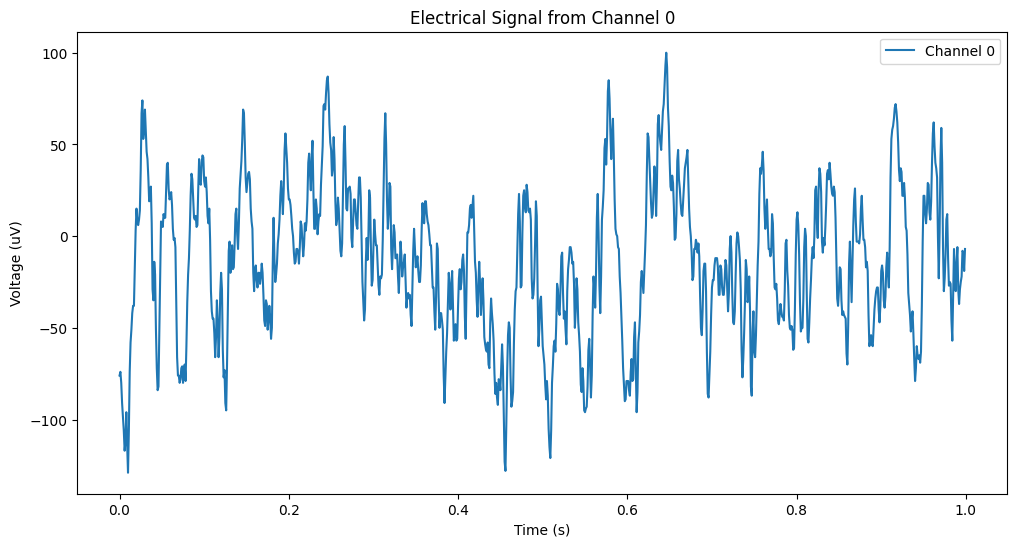

In [13]:
# Plot a portion of the data
plt.figure(figsize=(12, 6))
plt.plot(a1_timestamps[:1000], a1_data[:1000, 0], label="Channel 0")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (uV)")
plt.title("Electrical Signal from Channel 0")
plt.legend()
plt.show()

## Other Data

In [14]:
# Get the trials data
trials_df = example_data.trials.to_dataframe()
trials_df.head()

,start_time,stop_time,target_presentation_time,go_cue_time,reaction_time,move_begins_time,move_ends_time,discard_trial,task_success,trial_type,...,correct_reach,maze_num_targets,maze_num_barriers,novel_maze,target_positions,frame_details,hit_target_position,target_size,barrier_info,timeseries
id,,,,,,,,,,,,,,,,,,,,,
0,64.551267,68.191133,65.485267,66.316267,0.310,66.588267,66.903267,0,1,5,...,1,1,0,0,"[[132, 46]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[132, 46]",13,[],"[(0, 3051, Eye pynwb.behavior.SpatialSeries at..."
1,69.186267,72.581167,70.071267,70.701267,0.325,70.988267,71.293267,0,1,7,...,1,1,0,0,"[[0, 86]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[-9, 86]",13,[],"[(3051, 2806, Eye pynwb.behavior.SpatialSeries..."
2,73.676400,76.861367,74.623400,74.720400,0.365,75.053400,75.478400,0,1,1,...,1,3,6,0,"[[111, 85], [133, 0], [0, 0]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[111, 85]",13,"[[-69.0, -16.0, 69.0, 13.0], [-120.0, -62.0, 1...","[(5857, 2501, Eye pynwb.behavior.SpatialSeries..."
3,78.511533,81.971467,79.292533,80.106533,0.340,80.413533,80.673533,0,1,0,...,0,1,5,1,"[[0, 0]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[-55, -81]",13,"[[141.0, 21.0, 11.0, 41.0], [82.0, 76.0, 40.0,...","[(8358, 2861, Eye pynwb.behavior.SpatialSeries..."
4,82.991300,85.926167,83.677300,84.091300,0.355,84.408300,84.683300,0,1,3,...,1,1,0,0,"[[0, 0]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[-116, -5]",13,[],"[(11219, 2391, Eye pynwb.behavior.SpatialSerie..."


In [15]:
# Get the first trial
first_trial = trials_df.iloc[0]
first_trial

start_time                                                          64.551267
stop_time                                                           68.191133
target_presentation_time                                            65.485267
go_cue_time                                                         66.316267
reaction_time                                                            0.31
move_begins_time                                                    66.588267
move_ends_time                                                      66.903267
discard_trial                                                               0
task_success                                                                1
trial_type                                                                  5
trial_version                                                               0
proto_trial                                                                 0
maze_condition                                                  

In [16]:
# Behavior data linked in trials
first_trial['timeseries'][0], first_trial['timeseries'][0].data.shape

(TimeSeriesReference(idx_start=np.int32(0), count=np.int32(3051), timeseries=Eye pynwb.behavior.SpatialSeries at 0x5289302960
 Fields:
   comments: no comments
   conversion: nan
   data: <HDF5 dataset "data": shape (4696343, 2), type "<f8">
   description: no description
   interval: 1
   offset: 0.0
   reference_frame: screen center
   resolution: -1.0
   timestamps: <HDF5 dataset "timestamps": shape (4696343,), type "<f8">
   timestamps_unit: seconds
   unit: meters
 ),
 (3051, 2))

In [17]:
# Count discard trial across all trials
discard_counts = trials_df['discard_trial'].value_counts()
print("\nDiscard Counts:")
print(discard_counts)

# Count task success across all trials
task_success_counts = trials_df['task_success'].value_counts()
print("\nTask Success Counts:")
print(task_success_counts)

# Count correct reach across all trials
correct_reach_counts = trials_df['correct_reach'].value_counts()
print("\nCorrect Reach Counts:")
print(correct_reach_counts)

# Count trial type across all trials
trial_type_counts = trials_df['trial_type'].value_counts()
print("\nTrial Type Counts:")
print(trial_type_counts)


Discard Counts:
discard_trial
0    1588
Name: count, dtype: int64

Task Success Counts:
task_success
1    1573
0      15
Name: count, dtype: int64

Correct Reach Counts:
correct_reach
1    1015
0     573
Name: count, dtype: int64

Trial Type Counts:
trial_type
0     184
9     129
2     129
6     128
11    127
8     122
7     115
3     113
1     111
4     110
12    107
10    107
5     106
Name: count, dtype: int64


In [18]:
# Get the electrodes data
electrodes_df = example_data.electrodes.to_dataframe()
electrodes_df.head()

,x,y,z,imp,location,filtering,group,group_name,gain,offset
id,,,,,,,,,,
1,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,1 pynwb.ecephys.ElectrodeGroup at 0x5289599376...,1,1.0,0.0
2,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,1 pynwb.ecephys.ElectrodeGroup at 0x5289599376...,1,1.0,0.0
3,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,1 pynwb.ecephys.ElectrodeGroup at 0x5289599376...,1,1.0,0.0
4,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,1 pynwb.ecephys.ElectrodeGroup at 0x5289599376...,1,1.0,0.0
5,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,1 pynwb.ecephys.ElectrodeGroup at 0x5289599376...,1,1.0,0.0


In [19]:
# Get the units data
units_df = example_data.units.to_dataframe()
units_df.head()

,spike_times,obs_intervals,electrodes,electrode_group
id,,,,
0,"[64.68116666666667, 64.8448, 65.02746666666667...","[[64.55126666666666, 68.19113333333334], [69.1...",x y z imp location ...,1 pynwb.ecephys.ElectrodeGroup at 0x5289599376...
1,"[4469.972166666666, 4469.983066666667, 4470.03...","[[64.55126666666666, 68.19113333333334], [69.1...",x y z imp location ...,1 pynwb.ecephys.ElectrodeGroup at 0x5289599376...
2,"[64.57156666666667, 64.709, 64.73143333333334,...","[[64.55126666666666, 68.19113333333334], [69.1...",x y z imp location ...,1 pynwb.ecephys.ElectrodeGroup at 0x5289599376...
3,"[64.55590000000001, 64.5644, 64.58023333333334...","[[64.55126666666666, 68.19113333333334], [69.1...",x y z imp location ...,1 pynwb.ecephys.ElectrodeGroup at 0x5289599376...
4,"[64.55216666666666, 64.5821, 64.85373333333334...","[[64.55126666666666, 68.19113333333334], [69.1...",x y z imp location ...,1 pynwb.ecephys.ElectrodeGroup at 0x5289599376...


# Visualizing the data

## Behavioral Data

In [20]:
# Enum for index of each position type in the trials dataframe
class Position(Enum):
    Eye = 0
    Hand = 1 
    Cursor = 2

def plot_behavioral_trial(trial_index: int, position_type: Position):
    """
    Plot the behavioral data for a given trial and position type

    Parameters:
    - trial_index: The index of the trial to plot
    - position_type: The position type to plot
    """
    # Get the trial data
    trial = trials_df.iloc[trial_index]

    # Get the position data
    position_data = trial['timeseries'][position_type.value]
    assert position_data.timeseries.name == position_type.name

    # Get the position data
    position_x = position_data.data[:, 0]
    position_y = position_data.data[:, 1]

    # Get the target positions
    target_positions = trial['target_positions']

    # Plot the position data
    plt.figure(figsize=(8, 8))
    plt.plot(position_x, position_y, color='blue', alpha=0.5)

    # Plot the start and end positions
    plt.scatter(position_x[0], position_y[0], color='red', label="Start Position", zorder=3)
    plt.scatter(position_x[-1], position_y[-1], color='green', label="End Position", zorder=3)

    # Plot the target positions
    for i, target_position in enumerate(target_positions):
        plt.scatter(target_position[0], target_position[1], color='yellow', label=f"Target Position {i}", zorder=3)

    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title(f"{position_type.name} Trajectory During Reaching: Trial {trial_index}")
    plt.legend()
    plt.show()

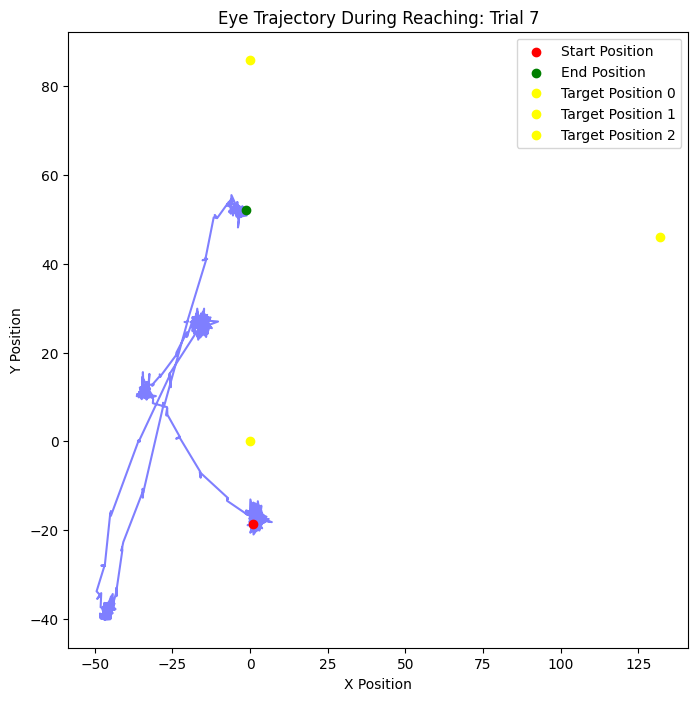

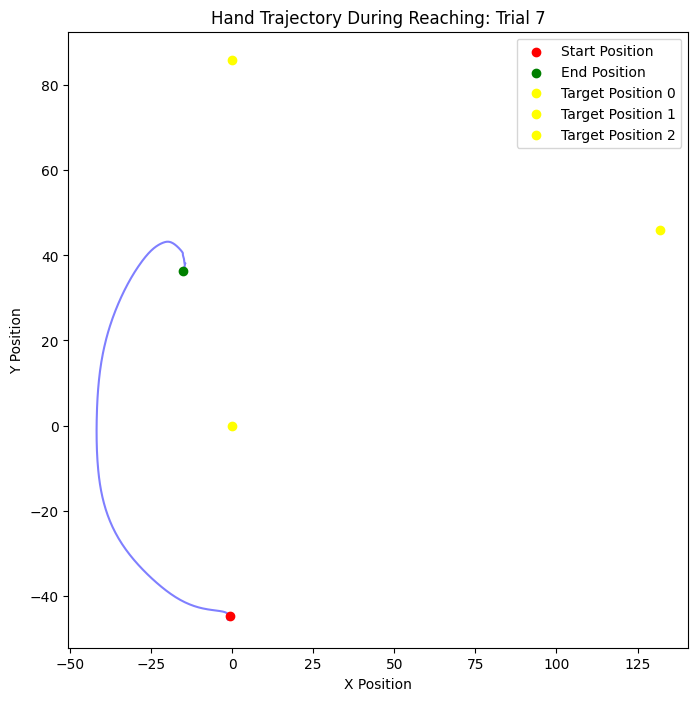

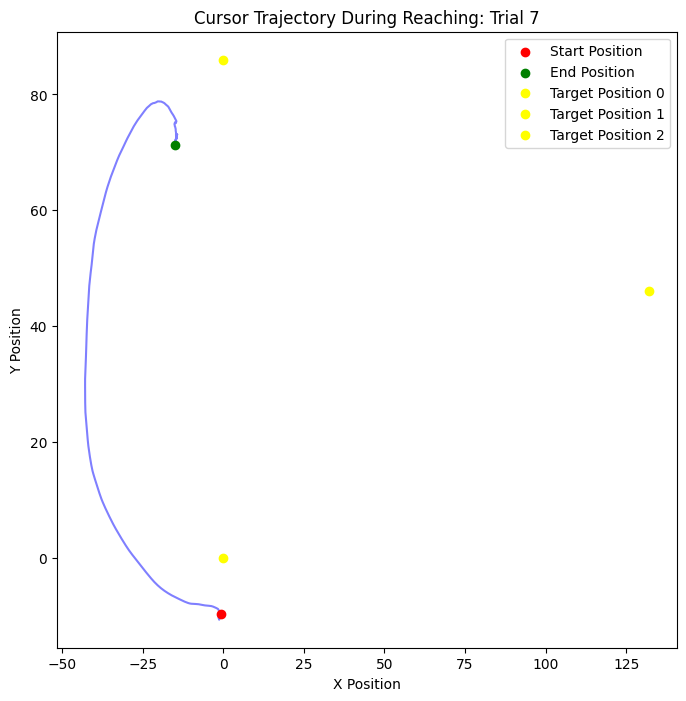

In [119]:
trial_index = 7
plot_behavioral_trial(trial_index, Position.Eye)
plot_behavioral_trial(trial_index, Position.Hand)
plot_behavioral_trial(trial_index, Position.Cursor)

## Electrophysiological Data

### Spike Data

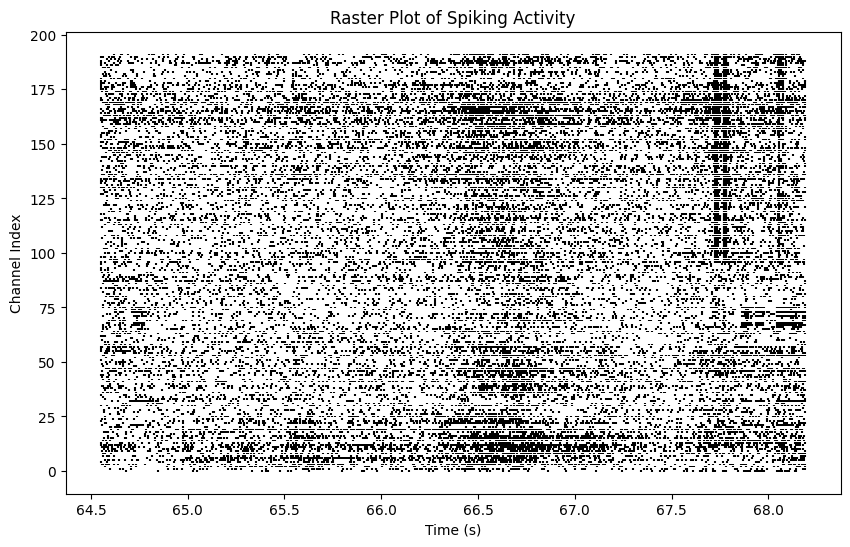

In [22]:
trial_index = 0

plt.figure(figsize=(10, 6))

# Get the spike times
for i in range(len(units_df)):
    unit = units_df.iloc[i]
    spike_times = unit['spike_times']

    # Get spikes for trial
    trial_interval = unit['obs_intervals'][trial_index]
    aligned_spikes = []
    aligned_spikes.extend(spike_times[(spike_times >= trial_interval[0]) & (spike_times <= trial_interval[1])])
    
    plt.eventplot(aligned_spikes, lineoffsets=i, linelengths=0.8, color='black')

plt.xlabel("Time (s)")
plt.ylabel("Channel Index")
plt.title("Raster Plot of Spiking Activity")
plt.show()

In [23]:
def plot_psth(spike_times, trial_intervals, event_times, title="Peri-Stimulus Time Histogram (PSTH)", window=(-0.5, 1.0), bin_size=0.05):
    """
    Plot the peri-stimulus time histogram (PSTH) of the spike times

    Parameters:
    - spike_times: The spike times to plot
    - trial_intervals: The trial intervals to plot
    - event_times: The event times to align the spikes to
    """
    bins = np.arange(window[0], window[1] + bin_size, bin_size)
    histograms = np.zeros((len(spike_times), len(bins) - 1))

    assert len(trial_intervals) == len(event_times)
    for trial_interval, event_time in zip(trial_intervals, event_times):
        aligned_spikes = []
        aligned_spikes.extend(spike_times[(spike_times >= trial_interval[0]) & (spike_times <= trial_interval[1])] - event_time)
        histograms[i] += np.histogram(aligned_spikes, bins=bins)[0]

    # Average across neurons
    mean_psth = histograms.mean(axis=0) / len(event_times) / bin_size  # Convert to firing rate (Hz)

    plt.figure(figsize=(8, 4))
    plt.bar(bins[:-1], mean_psth, width=0.05, color='black')
    plt.xlabel("Time from Event (s)")
    plt.ylabel("Firing Rate (Hz)")
    plt.title(title)
    plt.show()

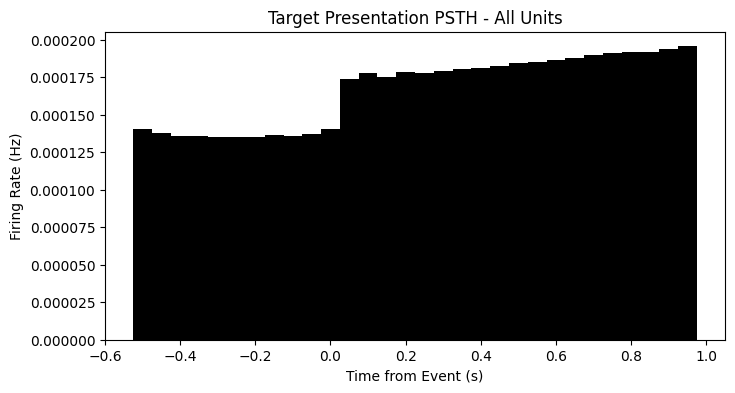

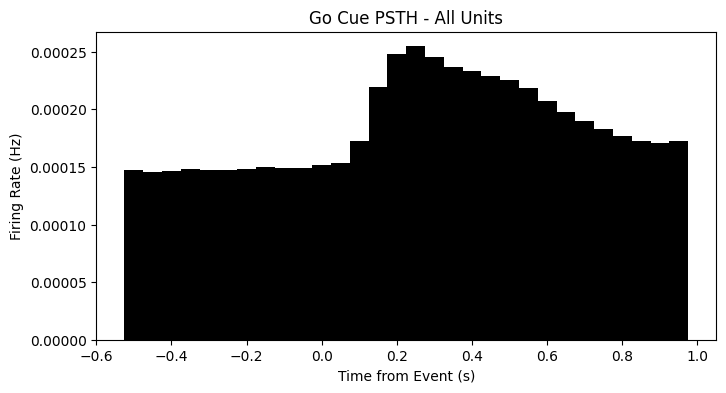

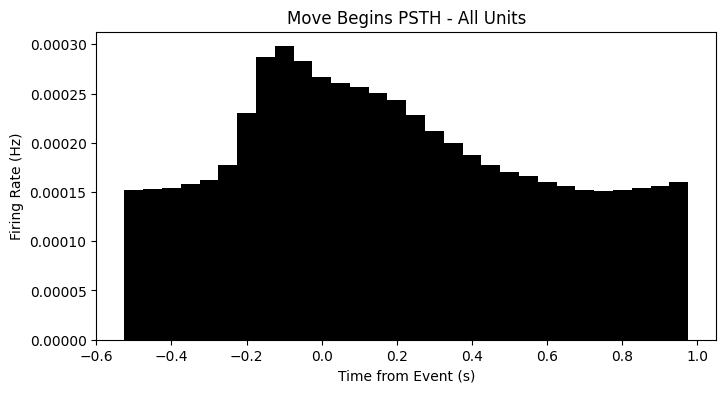

In [24]:
# Plot the PSTH for the target presentation, go cue, and move begins
# Use all spike times from all units
all_spike_times = np.concatenate(units_df['spike_times'].to_numpy())
trial_intervals = units_df['obs_intervals'][0]

target_presentation_times = example_data.trials["target_presentation_time"]
go_cue_times = example_data.trials["go_cue_time"]
move_begins_times = example_data.trials["move_begins_time"]

plot_psth(all_spike_times, trial_intervals, target_presentation_times, title="Target Presentation PSTH - All Units")
plot_psth(all_spike_times, trial_intervals, go_cue_times, title="Go Cue PSTH - All Units")
plot_psth(all_spike_times, trial_intervals, move_begins_times, title="Move Begins PSTH - All Units")

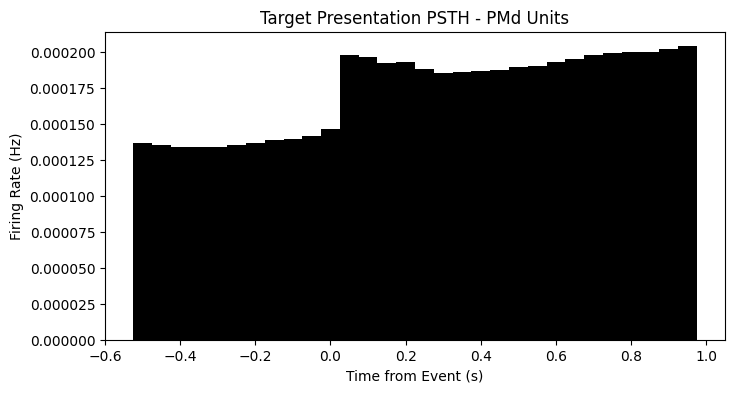

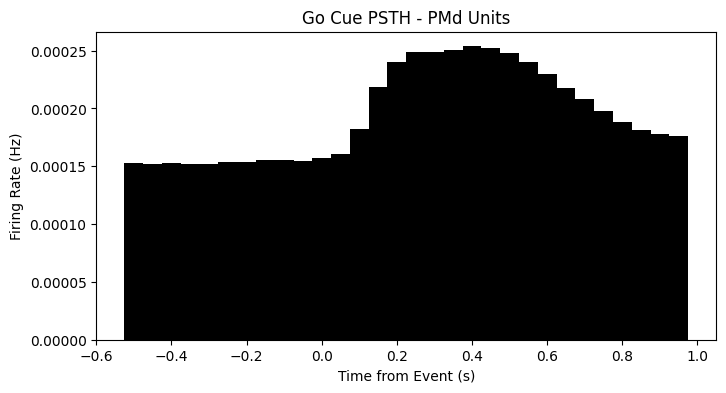

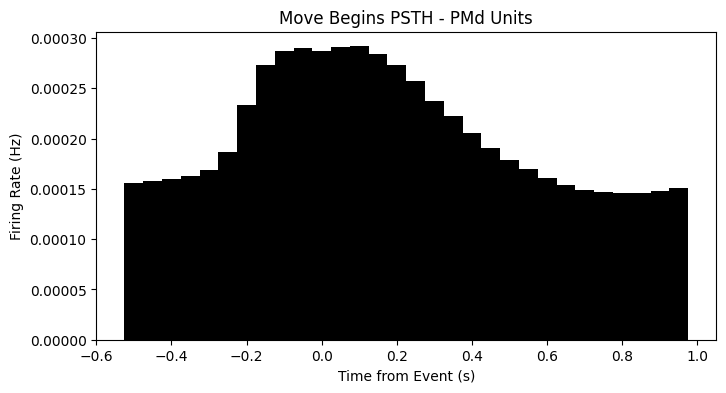

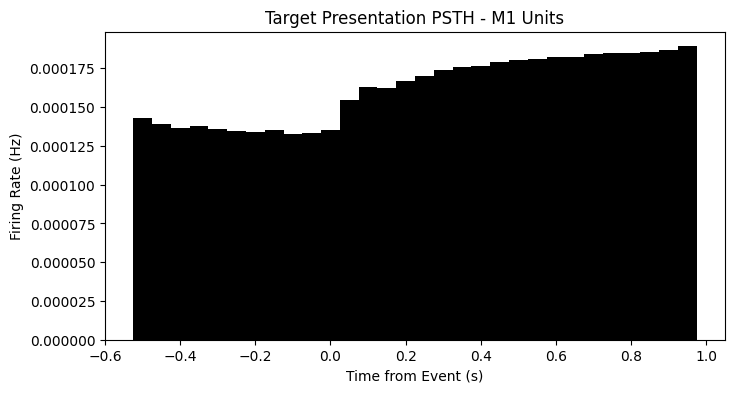

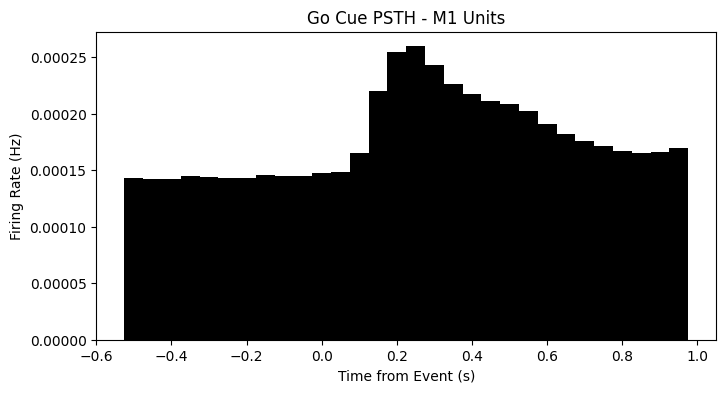

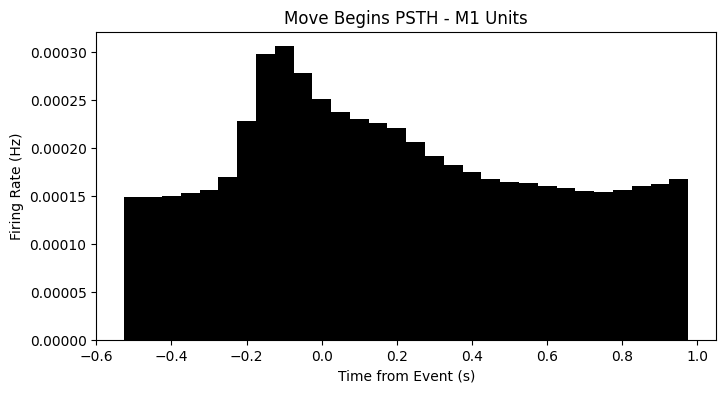

In [25]:
# Plot the PSTH for the target presentation, go cue, and move begins
# Seperate by electrode group
PMd_units = units_df[:int(len(units_df)/2)]
assert all(PMd_units['electrode_group'] == PMd_units['electrode_group'].iloc[0])
PMd_spike_times = np.concatenate(PMd_units['spike_times'].to_numpy())

trial_intervals = units_df['obs_intervals'][0]

target_presentation_times = example_data.trials["target_presentation_time"]
go_cue_times = example_data.trials["go_cue_time"]
move_begins_times = example_data.trials["move_begins_time"]

plot_psth(PMd_spike_times, trial_intervals, target_presentation_times, title=f"Target Presentation PSTH - PMd Units")
plot_psth(PMd_spike_times, trial_intervals, go_cue_times, title=f"Go Cue PSTH - PMd Units")
plot_psth(PMd_spike_times, trial_intervals, move_begins_times, title=f"Move Begins PSTH - PMd Units")

M1_units = units_df[int(len(units_df)/2):]
assert all(M1_units['electrode_group'] == M1_units['electrode_group'].iloc[0])
M1_spike_times = np.concatenate(M1_units['spike_times'].to_numpy())

plot_psth(M1_spike_times, trial_intervals, target_presentation_times, title=f"Target Presentation PSTH - M1 Units")
plot_psth(M1_spike_times, trial_intervals, go_cue_times, title=f"Go Cue PSTH - M1 Units")
plot_psth(M1_spike_times, trial_intervals, move_begins_times, title=f"Move Begins PSTH - M1 Units")


# Signal processing

In [26]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [30]:
fs = electrical_series.rate
raw_data = a1_data[:5000]

# Filter the data for beta/gamma frequencies
beta_filtered_data = bandpass_filter(raw_data, 13, 30, fs) # 13-30 Hz, motor control
gamma_filtered_data = bandpass_filter(raw_data, 30, 100, fs) # 30-100 Hz, cognitive processing

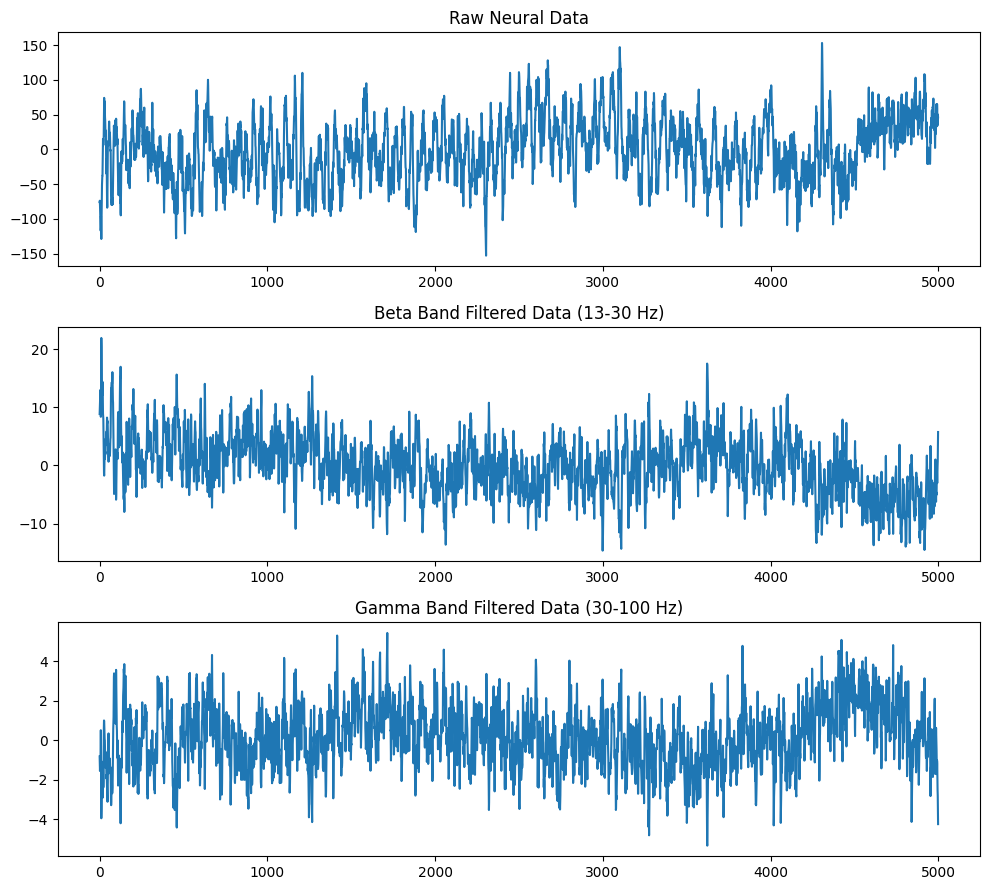

In [35]:
# Plot the original and filtered data
plt.figure(figsize=(10, 9))

plt.subplot(3, 1, 1)
plt.plot(raw_data[:5000, 0])
plt.title("Raw Neural Data")

plt.subplot(3, 1, 2)
plt.plot(beta_filtered_data[:5000, 0])
plt.title("Beta Band Filtered Data (13-30 Hz)")

plt.subplot(3, 1, 3)
plt.plot(gamma_filtered_data[:5000, 0])
plt.title("Gamma Band Filtered Data (30-100 Hz)")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter1d

def compute_firing_rate(spike_times, window_size=0.1):
    spike_counts = np.histogram(spike_times, bins=np.arange(0, len(spike_times) + window_size, window_size))[0]
    return gaussian_filter1d(spike_counts, sigma=2) / window_size


# Decoding

## Reaching Direction (Target Position) Decoding

### Single Session, Single Subject

In [49]:
# Start with single session for single subject
len(trials_df)

1588

In [50]:
# Filter for trials with single targets
single_target_trials = trials_df[trials_df['target_positions'].apply(len) == 1]
len(single_target_trials)

987

In [51]:
# Filter for trials with correct reach
correct_reach_trials = single_target_trials[single_target_trials['correct_reach'] == True]
len(correct_reach_trials)

687

In [52]:
# Extract target positions and count occurrences
target_positions = correct_reach_trials['target_positions'].apply(lambda x: tuple(x[0]))
target_counts = target_positions.value_counts()

print("\nTarget position counts for single-target trials:")
print(target_counts)


Target position counts for single-target trials:
target_positions
(0, 0)       234
(133, 0)      92
(0, 81)       84
(111, 85)     76
(0, 86)       72
(132, 46)     65
(132, 56)     64
Name: count, dtype: int64


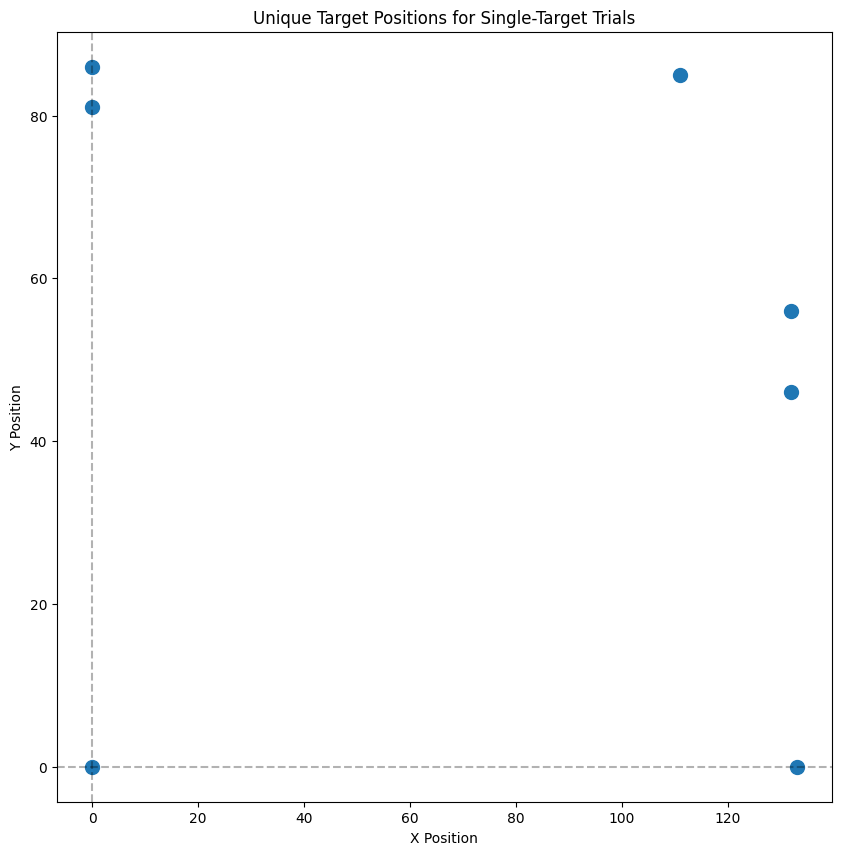

In [53]:
# Plot the target positions
unique_targets = np.array([list(pos) for pos in target_positions.unique()])

plt.figure(figsize=(10,10))
plt.scatter(unique_targets[:,0], unique_targets[:,1], s=100)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.xlabel('X Position')
plt.ylabel('Y Position') 
plt.title('Unique Target Positions for Single-Target Trials')
plt.show()

In [61]:
# Start with 4 classification categories: center, right, up, up-right
correct_reach_trials['target_category'] = correct_reach_trials['target_positions'].apply(lambda x: 'up-right' if x[0][0] > 0 and x[0][1] > 0 else 'up' if x[0][1] > 0 else 'right' if x[0][0] > 0 else 'center')
correct_reach_trials['target_category'].value_counts()

/var/folders/f2/s3wk5t7s1dn9r_9zl_1w03280000gn/T/ipykernel_91581/576637511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_reach_trials['target_category'] = correct_reach_trials['target_positions'].apply(lambda x: 'up-right' if x[0][0] > 0 and x[0][1] > 0 else 'up' if x[0][1] > 0 else 'right' if x[0][0] > 0 else 'center')


target_category
center      234
up-right    205
up          156
right        92
Name: count, dtype: int64

In [86]:
# Align the spike times to movement onset
aligned_spike_times_dict = {}
for idx, trial in correct_reach_trials.iterrows():
    aligned_spikes = []
    # Get the aligned spike times for each unit for this trial
    for unit in units_df.itertuples():
        # Use numpy array operations instead of list comprehension
        spike_times = np.array(unit.spike_times)
        mask = (spike_times >= trial['start_time']) & (spike_times <= trial['stop_time'])
        aligned = spike_times[mask] - trial['move_begins_time']
        aligned_spikes.append(aligned.tolist())
    aligned_spike_times_dict[idx] = aligned_spikes

In [106]:
bin_size = 0.01  # 10ms bins
time_window = (-0.5, 0.5)  # 500ms before and after move onset
bin_edges = np.arange(time_window[0], time_window[1] + bin_size, bin_size)

# Number of neurons
num_neurons = len(units_df)

# Initialize feature matrix (trials x neurons x time bins)
num_bins = len(bin_edges) - 1
num_trials = len(correct_reach_trials)
binned_spikes = np.zeros((num_trials, num_neurons, num_bins))

# Convert dict to a list
aligned_spike_times = list(aligned_spike_times_dict.values())

# Loop over neurons and trials
for t in range(num_trials):
    for n in range(num_neurons):
        trial_spike_times = aligned_spike_times[t][n]

        # Bin spike counts
        if len(trial_spike_times) == 0:
            # Handle empty spike times for a trial/neuron
            binned_spikes[t, n, :] = np.zeros(num_bins)
        else:
            binned_spikes[t, n, :], _, _ = binned_statistic(
                trial_spike_times, 
                values=None, 
                statistic="count", 
                bins=bin_edges
            )

# Reshape into (trials x features) for decoding
X = binned_spikes.reshape(num_trials, -1)  # Flatten neurons & time bins

In [189]:
# Use previously assigned labels
y = np.array(correct_reach_trials['target_category'])

# Split data into training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Calculate and print training accuracy
train_accuracy = clf.score(X_train, y_train)
print(f"Training accuracy: {train_accuracy:.2f}")


# Evaluate performance
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification accuracy: {accuracy:.2f}")

Training accuracy: 1.00
Classification accuracy: 0.97


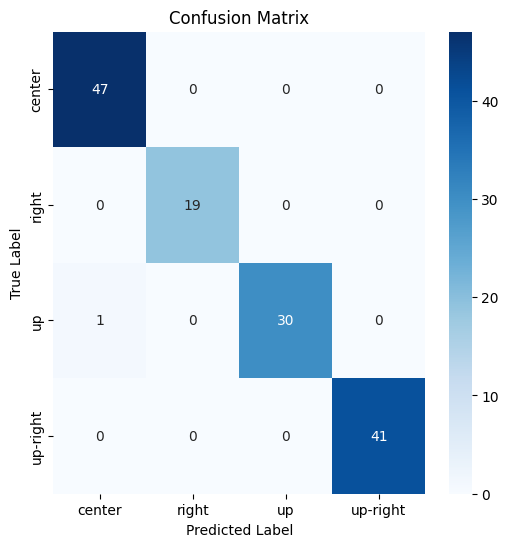

In [112]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [153]:
# Get model weights (coefficients) from trained classifier
weights = np.abs(clf.coef_)  # Take absolute values for importance

# Sum weights across time bins to get overall neuron importance
num_neurons = binned_spikes.shape[1]
neuron_importance = np.sum(weights.reshape(len(np.unique(y)), num_neurons, -1), axis=(0,2))

# Sort neurons by importance
sorted_indices = np.argsort(neuron_importance)[::-1]
sorted_importance = neuron_importance[sorted_indices]


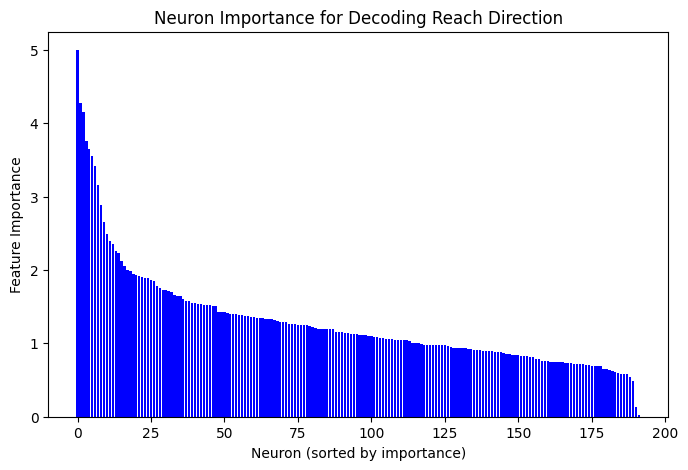

In [154]:
plt.figure(figsize=(8,5))
plt.bar(range(num_neurons), sorted_importance, color='blue')
plt.xlabel("Neuron (sorted by importance)")
plt.ylabel("Feature Importance")
plt.title("Neuron Importance for Decoding Reach Direction")
plt.show()

In [157]:
# Get the top 10 neurons
top_neurons = sorted_indices[:10]  # Get indices of top 10 neurons
print(f"Top 10 most important neurons: {top_neurons}")
# Top neurons are PMd neurons

Top 10 most important neurons: [  6  15  12  19  14   3  16  53  11 169]


### Across Sessions

In [158]:
def print_target_counts(correct_reach_trials, target_threshold=40):
    target_positions = correct_reach_trials['target_positions'].apply(lambda x: tuple(x[0]))
    target_counts = target_positions.value_counts()

    print("\nTarget position counts for single-target trials:")
    print(target_counts)

    # Plot the target positions
    unique_targets = np.array([list(pos) for pos in target_positions.unique()])

    plt.figure(figsize=(10,10))
    plt.scatter(unique_targets[:,0], unique_targets[:,1], s=100)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.axhline(y=target_threshold, color='r', linestyle='--', alpha=0.3)
    plt.axhline(y=-target_threshold, color='r', linestyle='--', alpha=0.3)
    plt.axvline(x=target_threshold, color='r', linestyle='--', alpha=0.3)
    plt.axvline(x=-target_threshold, color='r', linestyle='--', alpha=0.3)

    plt.xlabel('X Position')
    plt.ylabel('Y Position') 
    plt.title('Unique Target Positions for Single-Target Trials')
    plt.show()

def get_features_and_labels(session_data, target_threshold=40, print_counts=False):
    # Get the trials data
    trials_df = session_data.trials.to_dataframe()

    # Filter for trials with single targets
    single_target_trials = trials_df[trials_df['target_positions'].apply(len) == 1]
    
    # Filter for trials with correct reach
    correct_reach_trials = single_target_trials[single_target_trials['correct_reach'] == True]
    if print_counts:
        print_target_counts(correct_reach_trials, target_threshold=target_threshold)

    # Get the features
    def get_target_category(x):
        if x[0][0] > target_threshold and x[0][1] > target_threshold:
            return 'up-right'
        elif x[0][0] > target_threshold and x[0][1] < -target_threshold:
            return 'up-left'
        elif x[0][0] < -target_threshold and x[0][1] > target_threshold:
            return 'down-right'
        elif x[0][0] < -target_threshold and x[0][1] < -target_threshold:
            return 'down-left'
        elif x[0][0] > target_threshold:
            return 'right'
        elif x[0][0] < -target_threshold:
            return 'left'
        elif x[0][1] > target_threshold:
            return 'up'
        elif x[0][1] < -target_threshold:
            return 'down'
        else:
            return 'center'
        
    correct_reach_trials['target_category'] = correct_reach_trials['target_positions'].apply(get_target_category)
    if print_counts:
        print(correct_reach_trials['target_category'].value_counts())

    # Align the spike times to movement onset
    aligned_spike_times_dict = {}
    for idx, trial in correct_reach_trials.iterrows():
        aligned_spikes = []
        # Get the aligned spike times for each unit for this trial
        for unit in units_df.itertuples():
            # Use numpy array operations instead of list comprehension
            spike_times = np.array(unit.spike_times)
            mask = (spike_times >= trial['start_time']) & (spike_times <= trial['stop_time'])
            aligned = spike_times[mask] - trial['move_begins_time']
            aligned_spikes.append(aligned.tolist())
        aligned_spike_times_dict[idx] = aligned_spikes

    bin_size = 0.01  # 10ms bins
    time_window = (-0.5, 0.5)  # 500ms before and after move onset
    bin_edges = np.arange(time_window[0], time_window[1] + bin_size, bin_size)

    # Number of neurons
    num_neurons = len(units_df)

    # Initialize feature matrix (trials x neurons x time bins)
    num_bins = len(bin_edges) - 1
    num_trials = len(correct_reach_trials)
    binned_spikes = np.zeros((num_trials, num_neurons, num_bins))

    # Convert dict to a list
    aligned_spike_times = list(aligned_spike_times_dict.values())

    # Loop over neurons and trials
    for t in range(num_trials):
        for n in range(num_neurons):
            trial_spike_times = aligned_spike_times[t][n]

            # Bin spike counts
            if len(trial_spike_times) == 0:
                # Handle empty spike times for a trial/neuron
                binned_spikes[t, n, :] = np.zeros(num_bins)
            else:
                binned_spikes[t, n, :], _, _ = binned_statistic(
                    trial_spike_times, 
                    values=None, 
                    statistic="count", 
                    bins=bin_edges
                )

    # Reshape into (trials x features) for decoding
    X = binned_spikes.reshape(num_trials, -1)  # Flatten neurons & time bins

    # Use previously assigned labels
    y = np.array(correct_reach_trials['target_category'])

    return X, y


Target position counts for single-target trials:
target_positions
(0, 0)       234
(133, 0)      92
(0, 81)       84
(111, 85)     76
(0, 86)       72
(132, 46)     65
(132, 56)     64
Name: count, dtype: int64


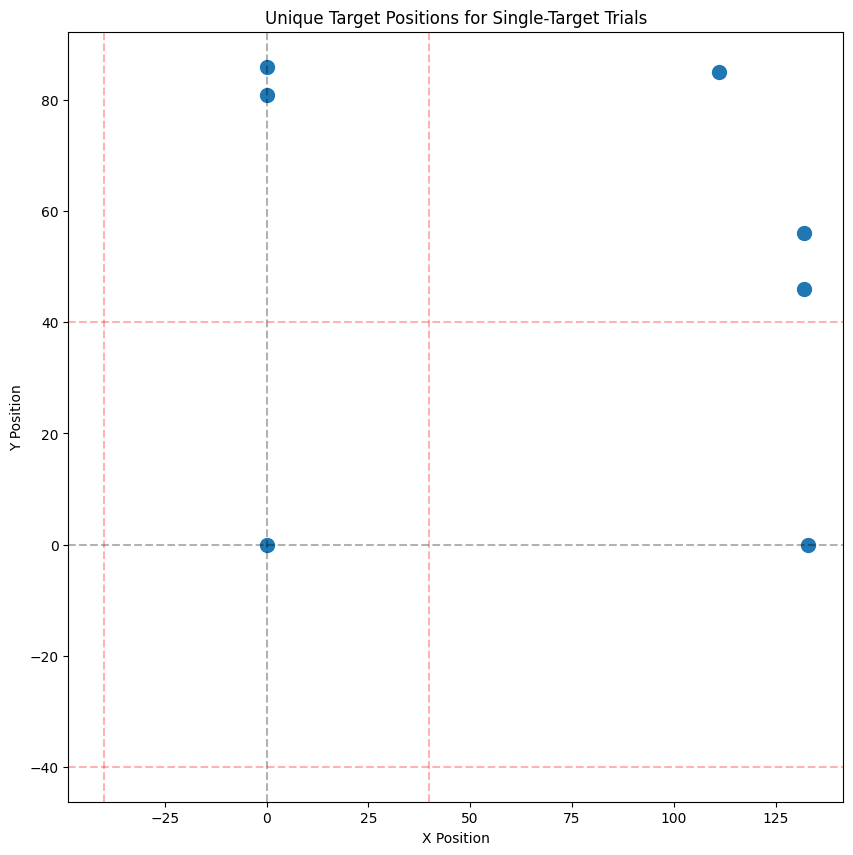

target_category
center      234
up-right    205
up          156
right        92
Name: count, dtype: int64


/var/folders/f2/s3wk5t7s1dn9r_9zl_1w03280000gn/T/ipykernel_91581/4272053260.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_reach_trials['target_category'] = correct_reach_trials['target_positions'].apply(get_target_category)



Target position counts for single-target trials:
target_positions
(123, 71)      111
(-77, 82)      104
(-130, -13)    102
(131, -55)      99
(133, -81)      98
(123, -81)      98
(-118, -83)     98
(-118, -7)      97
(132, 56)       94
Name: count, dtype: int64


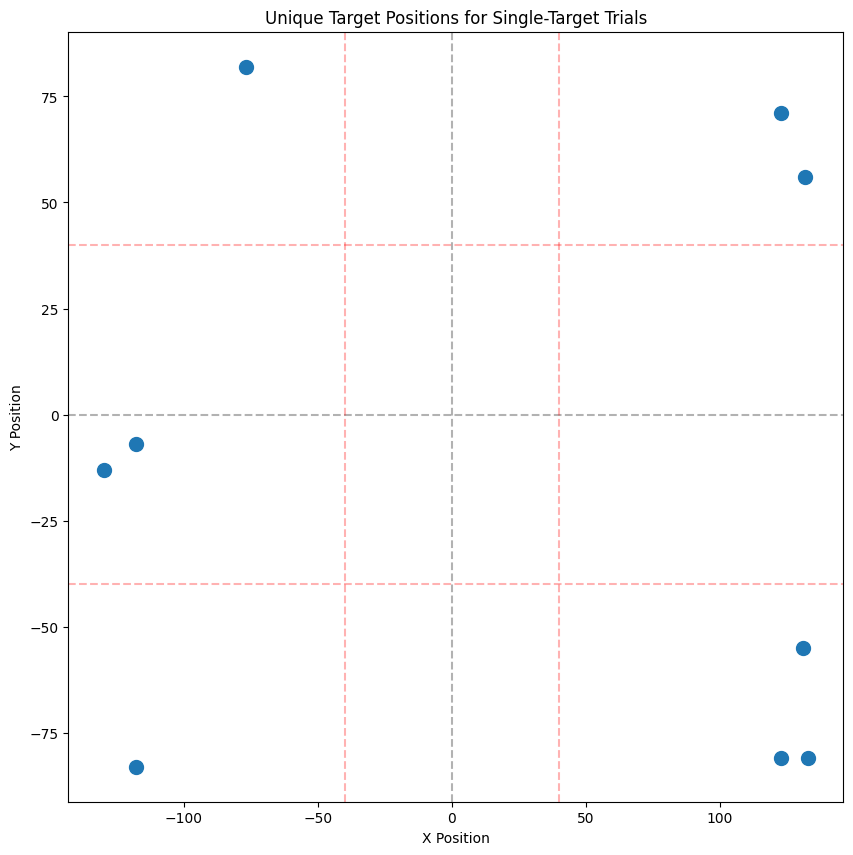

target_category
up-left       295
up-right      205
left          199
down-right    104
down-left      98
Name: count, dtype: int64


/var/folders/f2/s3wk5t7s1dn9r_9zl_1w03280000gn/T/ipykernel_91581/4272053260.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_reach_trials['target_category'] = correct_reach_trials['target_positions'].apply(get_target_category)



Target position counts for single-target trials:
target_positions
(132, 56)      94
(-108, 81)     54
(-116, -5)     48
(-118, -83)    47
(-121, 81)     46
(118, 72)      46
(123, 71)      46
(131, -55)     45
(-82, -86)     45
(113, -17)     45
(129, -29)     45
(94, -86)      45
(133, -81)     45
(132, -65)     44
(116, -77)     44
(27, 82)       44
(-108, 65)     44
(-130, -13)    43
(123, -81)     43
(-111, -82)    43
(133, -80)     43
(2, 82)        43
(-55, -81)     43
(-77, 82)      42
(-118, -7)     42
(-9, 86)       42
(-109, 2)      41
(131, -85)     41
(-123, 25)     39
(132, 46)      39
(2, 84)        39
(-105, -76)    38
(113, 79)      37
(111, 85)      36
(-116, -77)    36
Name: count, dtype: int64


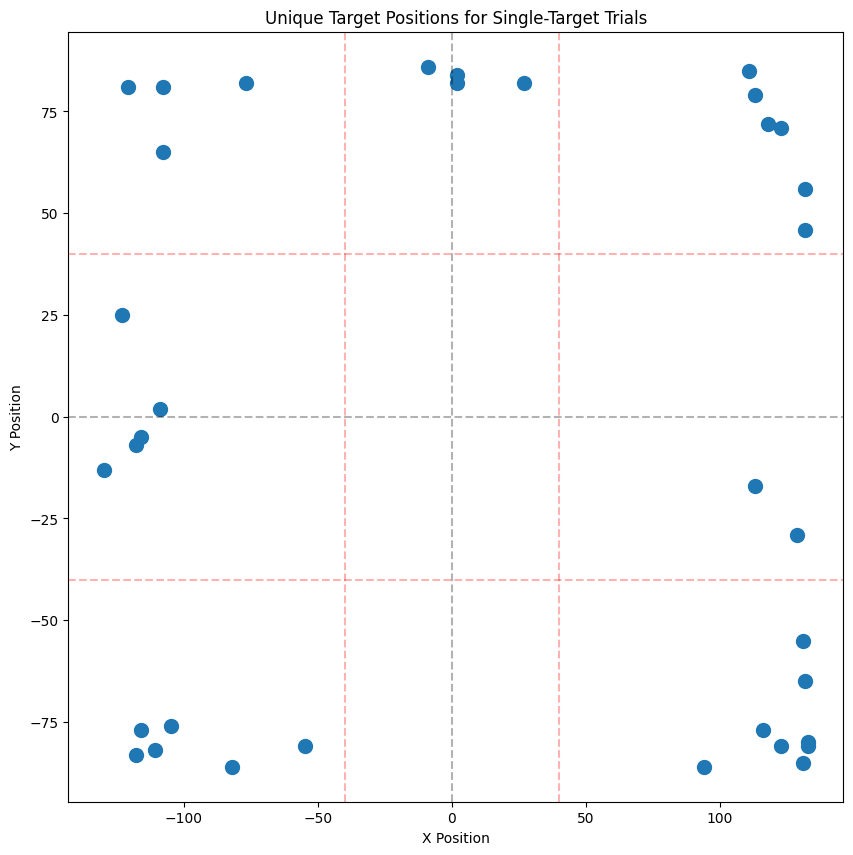

target_category
up-left       350
up-right      298
down-left     252
left          213
down-right    186
up            168
right          90
Name: count, dtype: int64


/var/folders/f2/s3wk5t7s1dn9r_9zl_1w03280000gn/T/ipykernel_91581/4272053260.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_reach_trials['target_category'] = correct_reach_trials['target_positions'].apply(get_target_category)



Target position counts for single-target trials:
target_positions
(-105, -76)    117
(116, -77)     114
(-108, 65)     113
(2, 84)        108
(113, -17)     105
(129, -29)     103
(113, 79)      101
(131, -85)      98
(-123, 25)      94
Name: count, dtype: int64


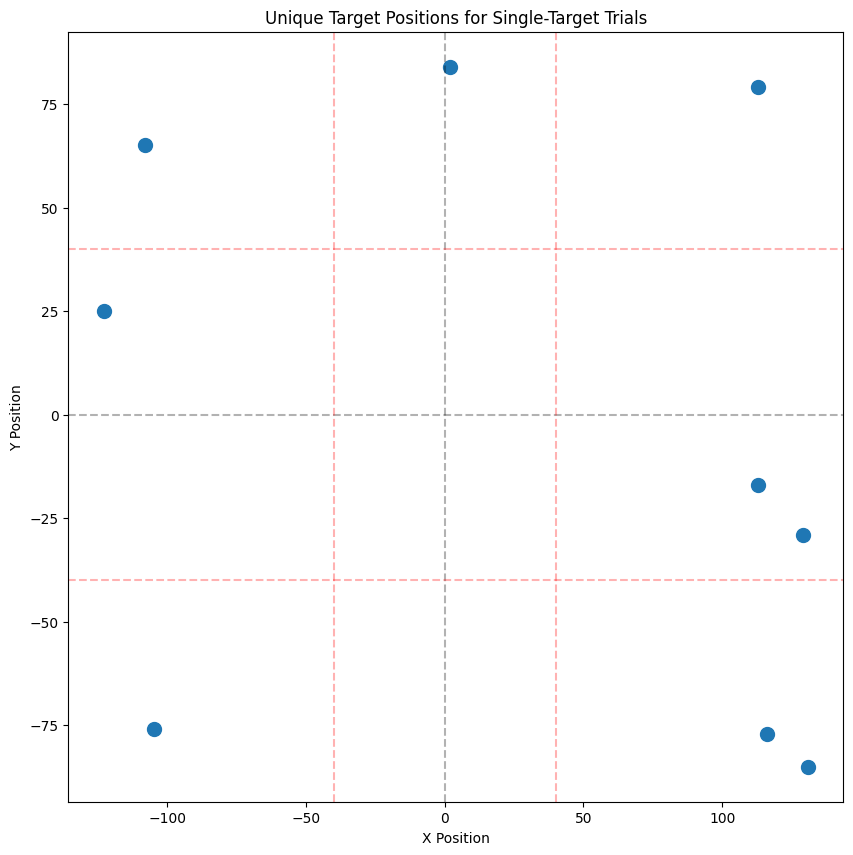

target_category
up-left       212
right         208
down-left     117
down-right    113
up            108
up-right      101
left           94
Name: count, dtype: int64


/var/folders/f2/s3wk5t7s1dn9r_9zl_1w03280000gn/T/ipykernel_91581/4272053260.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_reach_trials['target_category'] = correct_reach_trials['target_positions'].apply(get_target_category)


In [160]:
X_ses1, y_ses1 = get_features_and_labels(full_data["Jenkins"]["ses-20090912"], print_counts=True)
X_ses2, y_ses2 = get_features_and_labels(full_data["Jenkins"]["ses-20090916"], print_counts=True)
X_ses3, y_ses3 = get_features_and_labels(full_data["Jenkins"]["ses-20090918"], print_counts=True)
X_ses4, y_ses4 = get_features_and_labels(full_data["Jenkins"]["ses-20090923"], print_counts=True)

In [190]:
# Concatenate the features and labels
X_jenkins_full = np.concatenate([X_ses1, X_ses2, X_ses3, X_ses4], axis=0)
y_jenkins_full = np.concatenate([y_ses1, y_ses2, y_ses3, y_ses4], axis=0)

# Split data into training/testing
X_train_jenkins_full, X_test_jenkins_full, y_train_jenkins_full, y_test_jenkins_full = train_test_split(X_jenkins_full, y_jenkins_full, test_size=0.2, stratify=y_jenkins_full)

# Train classifier
clf_jenkins_full = LogisticRegression(max_iter=1000)
clf_jenkins_full.fit(X_train_jenkins_full, y_train_jenkins_full)

# Calculate and print training accuracy
train_accuracy_jenkins_full = clf_jenkins_full.score(X_train_jenkins_full, y_train_jenkins_full)
print(f"Training accuracy: {train_accuracy_jenkins_full:.2f}")

# Evaluate performance
y_pred_jenkins_full = clf_jenkins_full.predict(X_test_jenkins_full)
accuracy_jenkins_full = accuracy_score(y_test_jenkins_full, y_pred_jenkins_full)

print(f"Classification accuracy: {accuracy_jenkins_full:.2f}")

Training accuracy: 0.71
Classification accuracy: 0.33


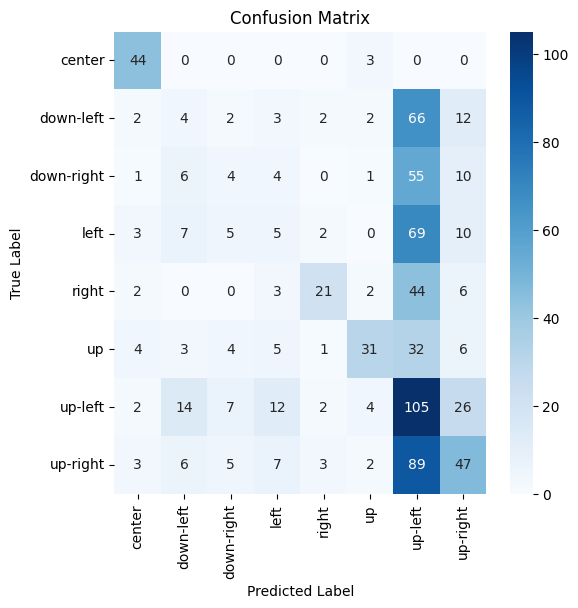

In [168]:
# Compute confusion matrix
cm_jenkins_full = confusion_matrix(y_test_jenkins_full, y_pred_jenkins_full)

# Plot
plt.figure(figsize=(6,6))
sns.heatmap(cm_jenkins_full, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_jenkins_full), yticklabels=np.unique(y_jenkins_full))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [188]:
# Look for imbalanced classes
y_jenkins_full_df = pd.Series(y_jenkins_full)
y_jenkins_full_df.value_counts()

up-left       857
up-right      809
left          506
down-left     467
up            432
down-right    403
right         390
center        234
Name: count, dtype: int64

In [195]:
# Downsample majority classes to match minority class size
min_class_size = y_jenkins_full_df.value_counts().min()
print(f"Downsampling all classes to {min_class_size} samples")

# Initialize arrays for balanced dataset
X_balanced = []
y_balanced = []

# For each unique class
for target in np.unique(y_jenkins_full):
    # Get indices for this class
    class_indices = np.where(y_jenkins_full == target)[0]
    
    # Downsample to min_class_size
    if len(class_indices) > min_class_size:
        X_downsampled, y_downsampled = resample(X_jenkins_full[class_indices], 
                                              y_jenkins_full[class_indices],
                                              n_samples=min_class_size,
                                              random_state=42)
        X_balanced.append(X_downsampled)
        y_balanced.append(y_downsampled)
        print(f"Downsampled {target} to {min_class_size} samples")
    else:
        X_balanced.append(X_jenkins_full[class_indices])
        y_balanced.append(y_jenkins_full[class_indices])
        print(f"No downsampling needed for {target}")

# Concatenate all balanced classes
X_jenkins_full_balanced = np.concatenate(X_balanced)
y_jenkins_full_balanced = np.concatenate(y_balanced)

Downsampling all classes to 234 samples
No downsampling needed for center
Downsampled down-left to 234 samples
Downsampled down-right to 234 samples
Downsampled left to 234 samples
Downsampled right to 234 samples
Downsampled up to 234 samples
Downsampled up-left to 234 samples
Downsampled up-right to 234 samples


In [196]:
# Split data into training/testing
X_train_jenkins_full_balanced, X_test_jenkins_full_balanced, y_train_jenkins_full_balanced, y_test_jenkins_full_balanced = train_test_split(X_jenkins_full_balanced, y_jenkins_full_balanced, test_size=0.2, stratify=y_jenkins_full_balanced)

# Train classifier
clf_jenkins_full_balanced = LogisticRegression(max_iter=1000)
clf_jenkins_full_balanced.fit(X_train_jenkins_full_balanced, y_train_jenkins_full_balanced)

# Calculate and print training accuracy
train_accuracy_jenkins_full_balanced = clf_jenkins_full_balanced.score(X_train_jenkins_full_balanced, y_train_jenkins_full_balanced)
print(f"Training accuracy: {train_accuracy_jenkins_full_balanced:.2f}")

# Evaluate performance
y_pred_jenkins_full_balanced = clf_jenkins_full_balanced.predict(X_test_jenkins_full_balanced)
accuracy_jenkins_full_balanced = accuracy_score(y_test_jenkins_full_balanced, y_pred_jenkins_full_balanced)

print(f"Classification accuracy: {accuracy_jenkins_full_balanced:.2f}")

Training accuracy: 0.71
Classification accuracy: 0.46


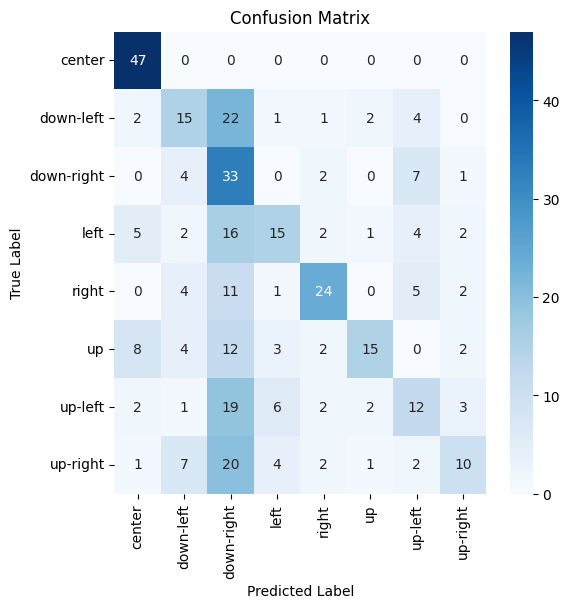

In [197]:
# Compute confusion matrix
cm_jenkins_full_balanced = confusion_matrix(y_test_jenkins_full_balanced, y_pred_jenkins_full_balanced)

# Plot
plt.figure(figsize=(6,6))
sns.heatmap(cm_jenkins_full_balanced, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_jenkins_full_balanced), yticklabels=np.unique(y_jenkins_full_balanced))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()